<a href="https://colab.research.google.com/github/yair040/AI_Course_Ramat_Gan-/blob/main/Lesson28_Find_A_Rule_From_Data/Finds_a_Rule_From_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Finds a Rule from Data

**Author:** Yair Levi  

This notebook demonstrates how a machine can discover a mathematical rule from data
using neuron-based models trained with backpropagation.

We solve the Celsius → Fahrenheit conversion problem using:
1. A **single neuron**
2. A **multi-neuron network**

No activation functions are used.


In [18]:

import os
import logging
from logging.handlers import RotatingFileHandler
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


## Logging Setup

We use INFO-level logging with a rotating ring buffer.


In [19]:

def setup_logging():
    os.makedirs('log', exist_ok=True)
    handler = RotatingFileHandler('log/app.log', maxBytes=16*1024*1024, backupCount=19)
    formatter = logging.Formatter('%(asctime)s | %(process)d | %(levelname)s | %(message)s')
    handler.setFormatter(formatter)
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.handlers = []
    logger.addHandler(handler)
    return logger

logger = setup_logging()
logger.info('Logging initialized')



## Dataset

The data is known in advance and contains **no noise**.


In [20]:

celsius_q = np.array([-40, -10, 0, 8, 15, 22, 38], dtype=float)
fahrenheit_a = np.array([-40, 14, 32, 46.4, 59, 71.6, 100], dtype=float)



## Utility Functions


In [21]:

def plot_error(history, title):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title(title)
    plt.grid(True)
    plt.show()

def draw_single_neuron(w, b):
    """
    Draw a single neuron network with input, output, weight, and bias labeled.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    # Input node
    input_circle = mpatches.Circle((0, 0), 0.3, color='lightblue', ec='black', linewidth=2)
    ax.add_patch(input_circle)
    ax.text(0, 0, 'Input\n(C°)', ha='center', va='center', fontsize=10, weight='bold')
    ax.text(0, -0.6, 'x', ha='center', va='top', fontsize=11, style='italic')

    # Output node
    output_circle = mpatches.Circle((4, 0), 0.3, color='lightcoral', ec='black', linewidth=2)
    ax.add_patch(output_circle)
    ax.text(4, 0, 'Output\n(F°)', ha='center', va='center', fontsize=10, weight='bold')
    ax.text(4, -0.6, 'y', ha='center', va='top', fontsize=11, style='italic')

    # Arrow with weight
    ax.annotate('', xy=(3.7, 0), xytext=(0.3, 0),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))

    # Weight label
    ax.text(2, 0.3, f'w = {w:.4f}', ha='center', va='bottom',
            fontsize=11, weight='bold', color='green',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

    # Bias label
    ax.text(4, 0.7, f'b = {b:.4f}', ha='center', va='bottom',
            fontsize=11, weight='bold', color='purple',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='plum', alpha=0.7))

    # Formula
    ax.text(2, -1.2, f'y = {w:.4f} × x + {b:.4f}', ha='center', va='top',
            fontsize=12, weight='bold',
            bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.5))

    ax.set_xlim(-1, 5)
    ax.set_ylim(-1.8, 1.5)
    ax.axis('off')
    ax.set_title('Single Neuron Network', fontsize=14, weight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def draw_multi_neuron(weights, biases, x_val=100.0):
    plt.figure(figsize=(8,3))

    plt.scatter(0, 0, s=300)
    plt.text(0, -0.5, f"Input x = {x_val}", ha='center')

    hidden_count = len(weights[0][0])
    hidden_outputs = []

    for i in range(hidden_count):
        y_pos = i - hidden_count/2
        w = weights[0][0][i]
        b = biases[0][i]
        h = w * x_val + b
        hidden_outputs.append(h)

        plt.scatter(2, y_pos, s=300)
        plt.arrow(0.2, 0, 1.6, y_pos, head_width=0.05, length_includes_head=True)
        plt.text(1, y_pos/2, f"w={w:.3f}\nb={b:.3f}", fontsize=9, ha='center')

    plt.scatter(4, 0, s=300)
    y_out = sum(hidden_outputs[i] * weights[1][i][0] for i in range(hidden_count)) + biases[1][0]
    plt.text(4, -0.5, f"Output y = {y_out:.2f}", ha='center')

    for i in range(hidden_count):
        y_pos = i - hidden_count/2
        w = weights[1][i][0]
        plt.arrow(2.2, y_pos, 1.6, -y_pos, head_width=0.05, length_includes_head=True)
        plt.text(3, y_pos/2, f"w={w:.3f}", fontsize=9, ha='center')

    plt.text(4, 0.8, f"bias = {biases[1][0]:.3f}", ha='center')
    plt.title("Multi-Neuron Network (Scalar Values After Training)")
    plt.axis('off')
    plt.show()


## Task A: Single Neuron Rule Discovery


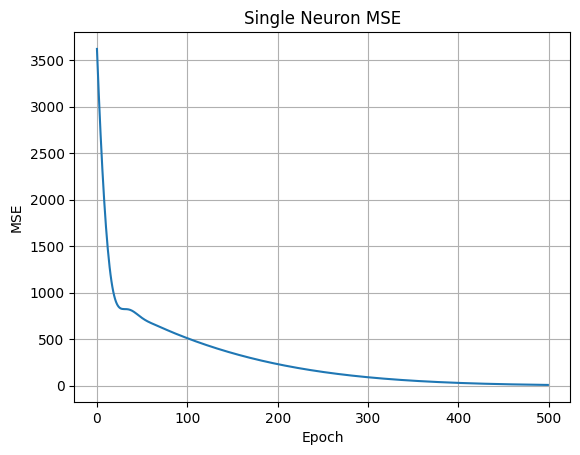

Learned rule: y = 1.8221 * x + 28.9654


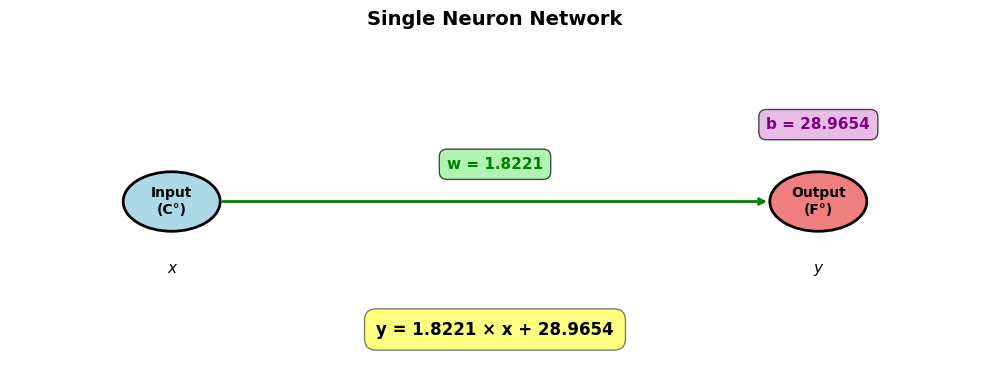

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
100°C prediction: 211.17369
Absolute error: 0.8263092


In [22]:

def train_single_neuron(x, y, epochs=500):
    model = keras.Sequential([
        keras.Input(shape=(1,)),
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1),
        loss='mse'
    )
    history = model.fit(x, y, epochs=epochs, verbose=0)
    return model, history

single_model, single_history = train_single_neuron(celsius_q, fahrenheit_a)
plot_error(single_history, 'Single Neuron MSE')

w, b = single_model.get_weights()
w = w[0][0]; b = b[0]
print(f'Learned rule: y = {w:.4f} * x + {b:.4f}')
draw_single_neuron(w, b)

pred = single_model.predict(np.array([[100]]))[0][0]
print('100°C prediction:', pred)
print('Absolute error:', abs(pred - 212))



## Task B: Multi-Neuron Rule Discovery


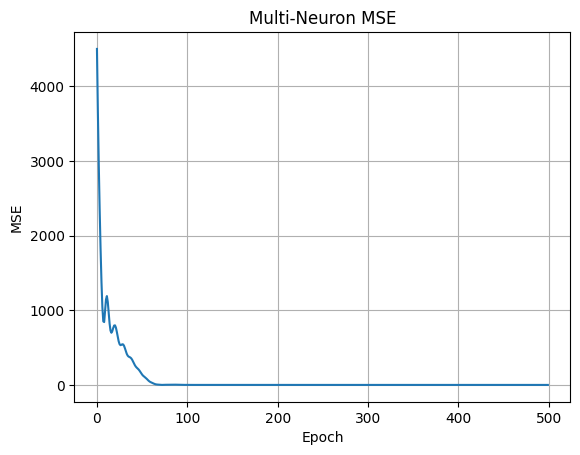

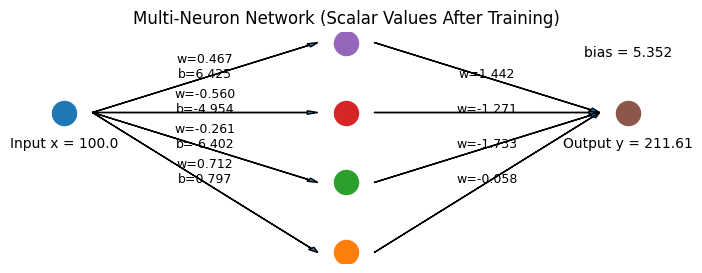

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
100°C prediction: 211.60559
Absolute error: 0.39440918


In [23]:

def train_multi_neuron(x, y, epochs=500):
    model = keras.Sequential([
        keras.Input(shape=(1,)),
        keras.layers.Dense(4),
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.1),
        loss='mse'
    )
    history = model.fit(x, y, epochs=epochs, verbose=0)
    return model, history


multi_model, multi_history = train_multi_neuron(celsius_q, fahrenheit_a)
plot_error(multi_history, 'Multi-Neuron MSE')

weights = multi_model.get_weights()[::2]
biases = multi_model.get_weights()[1::2]
draw_multi_neuron(weights, biases)

pred_multi = multi_model.predict(np.array([[100]]))[0][0]
print('100°C prediction:', pred_multi)
print('Absolute error:', abs(pred_multi - 212))



## Conclusion

- A **single neuron** is sufficient to discover the rule.
- A **multi-neuron network** converges to the same solution.
- Backpropagation without activation functions can discover mathematical rules.
- In **multi-neuron network** the MSE going down more rapidly that in **single neuron** and final absolute error is slightly smaller.
